# PeDistance Linear Regression

### Initial settings

In [2]:
import numpy as np
import torch
import pandas as pd
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Used as file name where saving model state
model_file_name="reg_state.pth"

# Get device based on available hardware
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# Convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.tensor(df.to_numpy()).float().to(device)

### Import Dataset

In [3]:
# Filtered fields read from dataset csv file
fields = [
    'Distance', 
    'PedTopLeftX', 
    'PedTopLeftY', 
    'PedTopRightX', 
    'PedTopRightY',
    'PedBottomLeftX', 
    'PedBottomLeftY',
    'PedBottomRightX',
    'PedBottomRightY'
]

df = pd.read_csv (r'./Dataset.csv', usecols=fields)
print(df.shape)

(689, 9)


### Splitting dataset


In [4]:
# sklearn function to split pandas dataframe into train and test set
train, test = train_test_split(df, test_size = 0.3)

In [5]:
# parsing dataframes to pytorch tensor
Y_training = df_to_tensor(train.Distance)
Y_testing = df_to_tensor(test.Distance)

print(Y_training.shape)
print(Y_testing.shape)

torch.Size([482])
torch.Size([207])


#### Getting width  height from raw 2D screen points

In [6]:
X_training = df_to_tensor(train.apply(lambda el :  pd.Series([abs(el.PedTopRightX - el.PedTopLeftX), abs(el.PedBottomLeftY - el.PedTopLeftY)], index=['width', 'height']), axis=1))
X_testing = df_to_tensor(test.apply(lambda el :  pd.Series([abs(el.PedTopRightX - el.PedTopLeftX), abs(el.PedBottomLeftY - el.PedTopLeftY)], index=['width', 'height']), axis=1))

print(X_training.shape)
print(X_testing.shape)

torch.Size([482, 2])
torch.Size([207, 2])


### Linear Regression Module

In [20]:
from pathlib import Path

class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        super(LinearRegressor, self).__init__()
        self.criterion = nn.MSELoss()
        self.linear = nn.Linear(in_size,out_size)       
        
    # used to train linear regressor
    def fit(self, X_training, Y_training, lr= 0.001, epochs=200000, momentum=0.0, reset_parameters= False):
        self.reset_parameters(reset_parameters)
        
        self.mean = X_training.mean(0)
        self.stds = X_training.std(0)
        X_training_norm = self._data_normalization(X_training)
                
        self.optimizer = torch.optim.SGD(reg.parameters(), lr=lr, momentum=momentum)
        self.writer = SummaryWriter('logs/linear_regressor_lr' + str(lr) + '_momentum' + str(momentum) + '_epochs' + str(epochs))
        
        self._training(X_training_norm, Y_training, lr, epochs, momentum)
       
    def _training(self, X_training_norm, Y_training, l, epochs, momentum):
        reg.train()
        for e in range(epochs):           
            preds_train = self.forward(X_training_norm)
            l = self.criterion(preds_train.view(-1),Y_training)

            self.writer.add_scalar('loss/train', l.item(), global_step=e)

            l.backward()

            self.optimizer.step()    
            self.optimizer.zero_grad()
            
#             reg.eval()
#             with torch.set_grad_enabled(False):
#                 preds_test = reg(X_testing_norm)
#                 l = criterion(preds_test.view(-1),Y_testing)
#                 writer.add_scalar('loss/test', l.item(), global_step=e)    
        
    # used to get prediction based on trained linear regressor
    def predict(self, X):  
        X_norm = self._data_normalization(X)
        return self.linear(X_norm)
       
    # used to get final score tensor and predicted tensor based on train or test features and labels
    def score(self, X, Y):
        Y_preds = self.predict(X)
        l = self.criterion(Y_preds.view(-1),Y)
        return l, Y_preds
    
    # used to reset parameters before training
    def reset_parameters(self, reset_parameters= False):
        if reset_parameters:
            for layer in self.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
    
    # used to load parameters and model state to make predictions or continue training
    def load_state(self, path):
        if Path(path).exists():
            checkpoint = torch.load(path)
            self.mean = checkpoint["mean"]
            self.stds = checkpoint["stds"]
            self.load_state_dict(checkpoint["model_state_dict"])
    
    # used to save trained model state
    def save_state(self, path):
         torch.save({
            'mean': self.mean,
            'stds': self.stds,
            'model_state_dict': self.state_dict(),
            }, path)
        
    def _data_normalization(self, data):
        return (data-self.mean)/self.stds        
    
    def forward(self,x):
        result = self.linear(x)
        return result    

### Modular Linear Regression

In [125]:
reg = LinearRegressor(2,1).to(get_device())

In [126]:
reg.load_state(model_file_name)

In [17]:
reg.fit(X_training, Y_training)
reg.save_state(model_file_name)

In [140]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23584), started 0:00:46 ago. (Use '!kill 23584' to kill it.)

In [127]:
loss_train, Y_train_preds = reg.score(X_training, Y_training)
print("Loss train: " + str(loss_train.item()))
for p,c in zip(Y_training, Y_train_preds):
      print([p.item(), c.item()])

Loss train: 3.1255710124969482
[8.32291030883789, 8.402792930603027]
[5.0554304122924805, 0.13966941833496094]
[10.745719909667969, 13.037776947021484]
[9.095480918884277, 10.969210624694824]
[18.3211727142334, 16.844572067260742]
[18.8629207611084, 17.15690803527832]
[7.16493034362793, 6.560630798339844]
[5.186280727386475, 1.212667465209961]
[12.050487518310547, 13.601448059082031]
[6.642959117889404, 6.205296039581299]
[18.772342681884766, 16.844572067260742]
[10.841412544250488, 12.34306812286377]
[9.012786865234375, 10.63880443572998]
[10.583412170410156, 12.990361213684082]
[17.75496482849121, 16.335376739501953]
[20.433074951171875, 16.86039924621582]
[17.374425888061523, 16.455339431762695]
[12.489852905273438, 14.465977668762207]
[13.587333679199219, 14.601700782775879]
[6.479678630828857, 4.774921417236328]
[13.669398307800293, 14.669628143310547]
[7.251957893371582, 7.975045680999756]
[20.085269927978516, 17.693273544311523]
[19.03744125366211, 16.973567962646484]
[9.4630250

In [16]:
loss_testing, Y_testing_preds = reg.score(X_testing, Y_testing)
print("Loss testing: " + str(loss_testing.item()))
for p,c in zip(Y_testing, Y_testing_preds):
    print([p.item(), c.item()])

Loss testing: 2.606541156768799
[6.190547943115234, 4.590981483459473]
[14.537843704223633, 15.664024353027344]
[10.52283763885498, 10.890642166137695]
[5.2639241218566895, 1.5521831512451172]
[10.358003616333008, 11.432764053344727]
[5.964507579803467, 3.836306571960449]
[10.81712818145752, 12.538619041442871]
[13.462961196899414, 14.424872398376465]
[7.010646820068359, 7.701183795928955]
[17.45148468017578, 17.001312255859375]
[7.5683746337890625, 7.250857830047607]
[15.371305465698242, 15.627278327941895]
[16.31889533996582, 15.850855827331543]
[5.03120756149292, 0.4069852828979492]
[19.537919998168945, 16.11485481262207]
[7.905259132385254, 9.262048721313477]
[12.0525541305542, 14.337760925292969]
[14.909192085266113, 14.424872398376465]
[18.79692268371582, 16.966150283813477]
[13.712966918945312, 15.207935333251953]
[21.625946044921875, 17.090007781982422]
[14.892918586730957, 16.05923080444336]
[10.568982124328613, 12.265181541442871]
[10.061871528625488, 11.277419090270996]
[19.

### Prevision on new data

Human Detected :  0


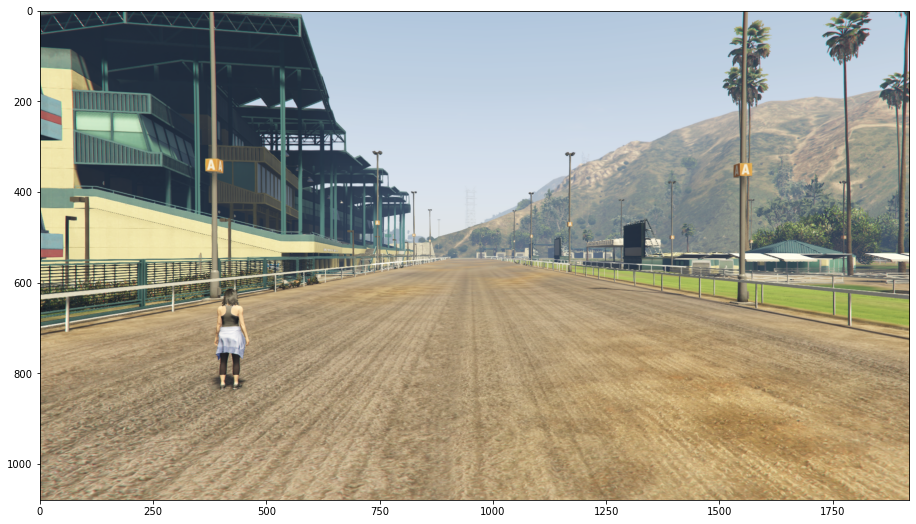

In [149]:
from __future__ import print_function
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2

# Initializing the HOG person 
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 

# Reading the Image 
image = cv2.imread('Test1.jpg')

# Detecting all humans 
(rects, weights) = hog.detectMultiScale(RGB_img,  
                                    winStride=(8, 8), # start (4,4) e salire, salendo si ha minor precisione (salta pixels)
                                    padding=(8, 8),   # start (8, 8), salire di potenze 2, aggiunge "bordo" di 0 all'immagine
                                    scale=1.3,
                                       )
# getting no. of human detected
print('Human Detected : ', len(rects))

# apply non-maxima suppression to the bounding boxes using a
# fairly large overlap threshold to try to maintain overlapping
# boxes that are still people
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])

# for (xA, yA, xB, yB) in rects:
#      cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)
        
pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

for (xA, yA, xB, yB) in pick:
    cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,9))
plt.imshow(RGB_img)


In [137]:
x = []
for (xA, yA, xB, yB) in pick:
    x.append([abs(xB - xA), abs(yB - yA)])

print(x)
x_tensor = torch.tensor(x).to(get_device())
print(x_tensor)
y_pred = reg.predict(x_tensor)
print(y_pred)

[[238, 475], [83, 166]]
tensor([[238, 475],
        [ 83, 166]], device='cuda:0', dtype=torch.int32)
tensor([[ 0.5451],
        [14.8779]], device='cuda:0', grad_fn=<AddmmBackward>)


# Test con YOLO (scaricare i file da importare)

In [142]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

[[[[0.00173881 0.00151192 0.00150446 ... 0.00093583 0.00079514
    0.00092573]
   [0.00082938 0.00092723 0.00101486 ... 0.00085229 0.00083741
    0.00089417]
   [0.00096823 0.00116937 0.00100752 ... 0.00145987 0.00091646
    0.00083264]
   ...
   [0.00092683 0.00088987 0.00115172 ... 0.00099829 0.00065629
    0.00082692]
   [0.00096984 0.00104037 0.00113876 ... 0.00102683 0.00121168
    0.00133075]
   [0.00084139 0.00118495 0.00131518 ... 0.00100159 0.00100004
    0.00126294]]

  [[0.0026011  0.00247849 0.00249322 ... 0.00084191 0.00074659
    0.00086511]
   [0.00076836 0.00133518 0.00155226 ... 0.00075982 0.00081565
    0.00083428]
   [0.00083945 0.00117106 0.00123775 ... 0.00135329 0.00090927
    0.0007582 ]
   ...
   [0.0023421  0.00239691 0.00264211 ... 0.00227698 0.00168382
    0.00199526]
   [0.00264488 0.00263119 0.00270366 ... 0.00245644 0.00259333
    0.00271448]
   [0.00220381 0.00278833 0.00279189 ... 0.00241178 0.00241984
    0.00266643]]

  [[0.00094823 0.00222573 0.002598

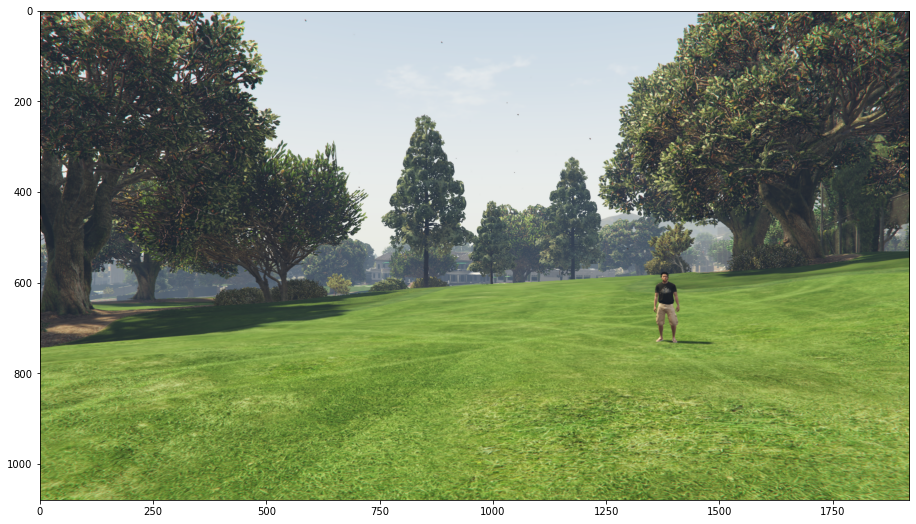

In [195]:
img = plt.imread('Test2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

classes = None
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

Width = img_rgb.shape[1]
Height = img_rgb.shape[0]

# read pre-trained model and config file
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# create input blob 
# set input blob for the network
# tmp = cv2.dnn.blobFromImage(img_rgb, 0.00392, (416,416), (0,0,0), True, crop=False)
# print(tmp)

net.setInput(cv2.dnn.blobFromImage(img_rgb, 0.00392, (416,416), (0,0,0), True, crop=False))

# run inference through the network
# and gather predictions from output layers
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
outs = net.forward(output_layers)

class_ids = []
confidences = []
boxes = []

#create bounding box 
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]      
        if confidence > 0.1:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)

#check if is people detection
for i in indices:
    i = i[0]
    box = boxes[i]  
    if class_ids[i]==0:
        label = str(classes[class_id]) 
        cv2.rectangle(img_rgb, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (0, 0, 0), 2)
        cv2.putText(img_rgb, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

plt.figure(figsize=(16,9))
plt.imshow(img_rgb)